# Solución de una EDO no lineal con RK45 adaptativo

Este notebook implementa una solución numérica para la ecuación:

$$
\frac{d^2y}{dt^2} = -6y^5
$$

Esta es una ecuación no lineal de segundo orden, y para resolverla numéricamente la convertimos en un sistema de primer orden. Utilizamos el método Runge-Kutta de orden 5(4) con control de paso adaptativo (RK45), que balancea precisión y eficiencia.

También analizamos la conservación de la energía del sistema, ya que este tipo de ecuaciones suelen derivar de sistemas conservativos.

## Paso 1: Importar librerías necesarias

Utilizamos `numpy` para operaciones numéricas y `matplotlib` para visualización. Estas son herramientas estándar en ciencia computacional en Python.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Paso 2: Definir parámetros y condiciones iniciales

Establecemos:
- Intervalo de integración: `[a, b]`
- Tolerancia para el error local del método adaptativo.
- Condiciones iniciales para `y(t)` y `y'(t)`
- Paso inicial `h` y límites máximos y mínimos permitidos para el paso.

También inicializamos arrays para uso interno en el método.

In [2]:
a = 0.0         # Tiempo inicial
b = 10.0        # Tiempo final
Tol = 1e-8      # Tolerancia para el control adaptativo del paso

y = np.zeros(2)     # y[0] = y(t), y[1] = y'(t)
ydumb = np.zeros(2) # Variable temporal para cálculo intermedio
fReturn = np.zeros(2)
err = np.zeros(2)

# Inicializar condición inicial
y[0] = 1.0      # y(0)
y[1] = 0.0      # y'(0)

n = 20          # Número inicial de pasos
h = (b - a)/n   # Paso inicial
t = a           # Tiempo inicial

# Límites del paso adaptativo
hmin = h / 64
hmax = h * 64

## Paso 3: Definir el sistema de EDOs de primer orden

La ecuación original de segundo orden se transforma en un sistema de dos ecuaciones de primer orden:

$$
\begin{cases}
y_0' = y_1 \\
y_1' = -6y_0^5
\end{cases}
$$

Esta forma es necesaria para aplicar cualquier método de integración numérica tipo Runge-Kutta.

In [3]:
def f(t, y):
    f_out = np.zeros(2)
    f_out[0] = y[1]
    f_out[1] = -6.0 * y[0]**5
    return f_out

## Paso 4: Inicializar listas para almacenar resultados

Guardamos los valores de tiempo, la función `y(t)` y su derivada `y'(t)` en listas para graficar luego.


In [4]:
T = [t]
Y0 = [y[0]]
Y1 = [y[1]]

## Paso 5: Bucle principal con Runge-Kutta 5(4)

Implementación del algoritmo de Runge-Kutta de orden 5(4). Se calculan seis `k` intermedios para estimar el nuevo valor de `y` y el error local.

La idea es:
- Aceptar el paso si el error es menor que la tolerancia.
- Ajustar el paso `h` dinámicamente para mantener el error bajo control.
- Calcular la energía del sistema (debe ser constante si el método conserva bien la dinámica).

También calculamos el error relativo en la energía para analizar el comportamiento del integrador.

In [5]:
flops = 0
sum_error = 0.0
Eexact = 1.0

while t < b:
    if t + h > b:
        h = b - t  # Asegurarse de no pasarse del tiempo final

    # Calcular los coeficientes de Runge-Kutta
    k1 = h * f(t, y)
    k2 = h * f(t + h/4, y + k1/4)
    k3 = h * f(t + 3*h/8, y + 3*k1/32 + 9*k2/32)
    k4 = h * f(t + 12*h/13, y + (1932*k1 - 7200*k2 + 7296*k3)/2197)
    k5 = h * f(t + h, y + (439*k1/216 - 8*k2 + 3680*k3/513 - 845*k4/4104))
    k6 = h * f(t + h/2, y + (-8*k1/27 + 2*k2 - 3544*k3/2565 +
                            1859*k4/4104 - 11*k5/40))

    # Estimar el error
    err = np.abs(k1/360 - 128*k3/4275 - 2197*k4/75240 + k5/50 + 2*k6/55)

    if (np.all(err < Tol) or h <= 2*hmin):
        # Aceptar el paso
        y = y + 25*k1/216 + 1408*k3/2565 + 2197*k4/4104 - k5/5
        t = t + h
        T.append(t)
        Y0.append(y[0])
        Y1.append(y[1])

    # Ajustar el paso
    if np.any(err == 0):
        s = 0
    else:
        s = 0.84 * (Tol * h / np.max(err))**0.25

    if s < 0.75 and h > 2*hmin:
        h = h / 2
    elif s > 1.5 and 2*h < hmax:
        h = h * 2

    # Calcular energía y error relativo
    E = y[0]**6 + 0.5*y[1]**2
    error = abs((E - Eexact)/Eexact)
    sum_error += error
    flops += 1

## Paso 6: Mostrar error promedio relativo

Este valor nos permite evaluar la conservación de la energía en el tiempo y por tanto, la estabilidad numérica del método.

In [6]:
print("<error> =", sum_error / flops, ", flops =", flops)

<error> = 1.1652779153847445e-07 , flops = 510


## Paso 7: Graficar resultados

Mostramos las soluciones numéricas:
- `y(t)` posición
- `y'(t)` velocidad

Ambas se visualizan como funciones del tiempo para observar el comportamiento oscilatorio del sistema.

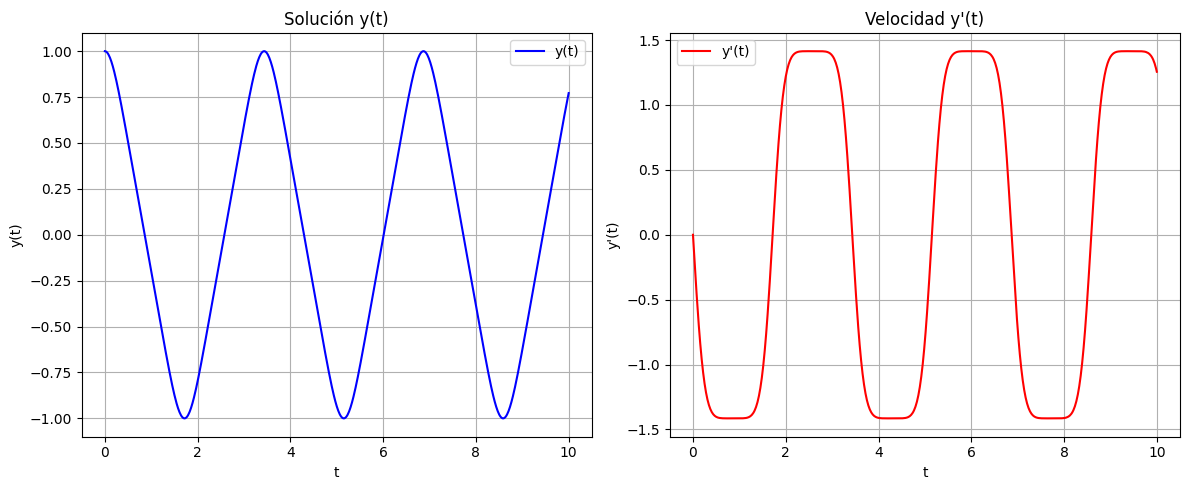

In [7]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(T, Y0, 'b-', label='y(t)')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.title('Solución y(t)')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(T, Y1, 'r-', label="y'(t)")
plt.xlabel('t')
plt.ylabel("y'(t)")
plt.title('Velocidad y\'(t)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()